Machine Learning for Aging & Longevity  
# 10-Year Coronary Heart Disease Risk Prediction  
**Dataset:** Framingham Heart Study (`framingham.csv`)  
**Source:** https://www.kaggle.com/datasets/aasheesh200/framingham-heart-study-dataset
---

### 1. Dataset Selection & Ethical Note

- **Framingham Heart Study (FHS)** meets all rubric requirements:
  - Mix of numerical and categorical features: Examples: numerical (age, blood pressure, cholesterol), categorical (gender, smoker status)
  - More than 10 predictors:  15 predictors after data cleaning
  - Binary target variable: Target variable: `TenYearCHD`
  - Sufficient dataset size : 4,240 rows


## Load libraries

In [161]:
# Load core libraries
import os  # file and path handling
import pandas as pd  # data manipulation and analysis
import numpy as np  # numerical operations
import matplotlib.pyplot as plt  # data visualization
import seaborn as sns  # advanced visualization
import missingno as msno  # visualization of missing data
from scipy.stats.mstats import winsorize  # handling outliers
import missingno as msno  # visualization of missing data

# Load preprocessing and transformation tools
from sklearn.impute import SimpleImputer  # handling missing values
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer  # data preprocessing
from sklearn.compose import ColumnTransformer  # applying transformations to specific columns

# Handle class imbalance and pipelines
from imblearn.pipeline import Pipeline # creating ML pipelines
from imblearn.combine import SMOTEENN

# Load model selection and tuning tools
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV  # model validation and tuning

# Load classification models
from sklearn.linear_model import LogisticRegression  # logistic regression classifier
from sklearn.neural_network import MLPClassifier  # neural network classifier
from sklearn.svm import SVC # SVM classifier
from xgboost import XGBClassifier  # gradient boosting classifier

# Load evaluation metrics
from sklearn.metrics import (
    roc_auc_score,  # compute Area Under ROC Curve
    accuracy_score,  # classification accuracy
    precision_score,  # precision metric
    recall_score,  # recall metric
    f1_score,  # harmonic mean of precision and recall
    confusion_matrix,  # confusion matrix
    roc_curve,  # compute ROC curve values for plotting (returns fpr, tpr, thresholds)
    precision_recall_curve,  # precision-recall curve values
    PrecisionRecallDisplay,  # precision-recall curve plotting
    average_precision_score
)
import time

# 2  Data Loading
We load the data into a `pandas` DataFrame and display first rows.

In [162]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('framingham.csv')

# Print the shape of the dataset (number of rows and columns)
print(f"Loaded data: {df.shape[0]} rows, {df.shape[1]} columns")

# Display the first few rows of the dataset
df.head()

Loaded data: 4240 rows, 16 columns


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Drop the `education` Feature

The `education` column represents the participant's education level. In the context of predicting 10-year coronary heart disease (CHD) risk, this feature is not directly related to physiological or clinical risk factors such as age, blood pressure, cholesterol, smoking status, or diabetes. Including features that are not medically or scientifically relevant can introduce noise, reduce model interpretability, and potentially bias the results. Therefore, we drop `education` to focus the analysis on variables with a clear and established relationship to

In [163]:
# Drop the 'education' column as it's not needed for analysis
df = df.drop(columns=['education'])

# 3  Exploratory Data Analysis (EDA)

## 3.1 Descriptive Stats & Missingness
Below we show full descriptive statistics plus missing counts and percentages.

In [164]:
# Generate descriptive statistics for all columns (including categorical) and transpose for readability
desc = df.describe(include='all').T

# Count the number of missing values per column
missing = df.isnull().sum().rename('missing_count')

# Calculate the percentage of missing values per column
missing_pct = (df.isnull().mean() * 100).rename('missing_pct')

# Combine descriptive statistics with missing value counts and percentages
stats = pd.concat([desc, missing, missing_pct], axis=1)

# Display combined statistics table
stats

,count,mean,std,min,25%,50%,75%,max,missing_count,missing_pct
male,4240.0,0.429245,0.495027,0.00,0.00,0.0,1.00,1.0,0,0.000000
age,4240.0,49.580189,8.572942,32.00,42.00,49.0,56.00,70.0,0,0.000000
currentSmoker,4240.0,0.494104,0.500024,0.00,0.00,0.0,1.00,1.0,0,0.000000
cigsPerDay,4211.0,9.005937,11.922462,0.00,0.00,0.0,20.00,70.0,29,0.683962
BPMeds,4187.0,0.029615,0.169544,0.00,0.00,0.0,0.00,1.0,53,1.250000
prevalentStroke,4240.0,0.005896,0.076569,0.00,0.00,0.0,0.00,1.0,0,0.000000
prevalentHyp,4240.0,0.310613,0.462799,0.00,0.00,0.0,1.00,1.0,0,0.000000
diabetes,4240.0,0.025708,0.158280,0.00,0.00,0.0,0.00,1.0,0,0.000000
totChol,4190.0,236.699523,44.591284,107.00,206.00,234.0,263.00,696.0,50,1.179245
sysBP,4240.0,132.354599,22.033300,83.50,117.00,128.0,144.00,295.0,0,0.000000


## 3.2 Missing-Data Visualization
`missingno.matrix` gives an intuitive overview of NaN patterns.

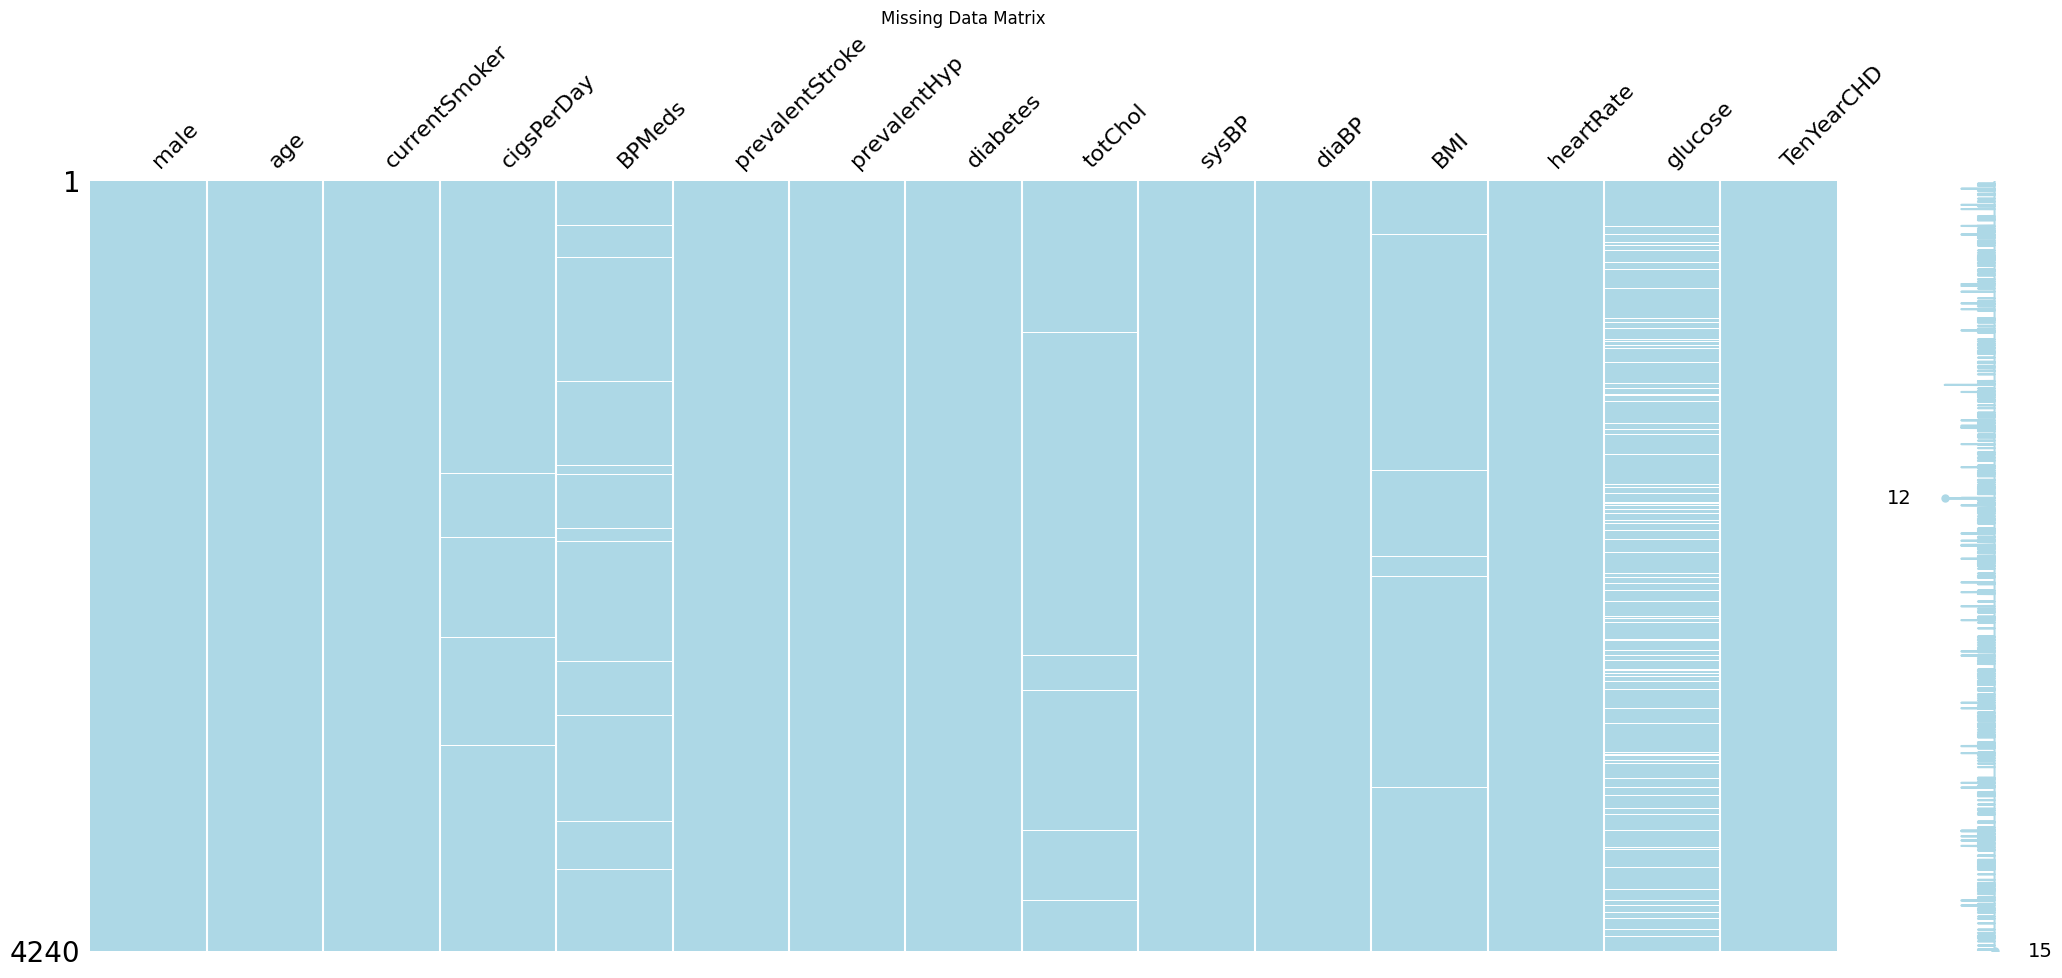

In [165]:
# Visualize missing data structure as a matrix plot
msno.matrix(df, color=(0.6784313725490196, 0.8470588235294118, 0.9019607843137255))  # Steel blue RGB values
plt.title('Missing Data Matrix')

# Save the figure to the 'figures' directory BEFORE showing it
plt.savefig('figures/missing_data_matrix.png')
plt.show()

## 3.3 Feature Distributions & Outliers
Histograms + KDE and boxplots for every numerical feature.

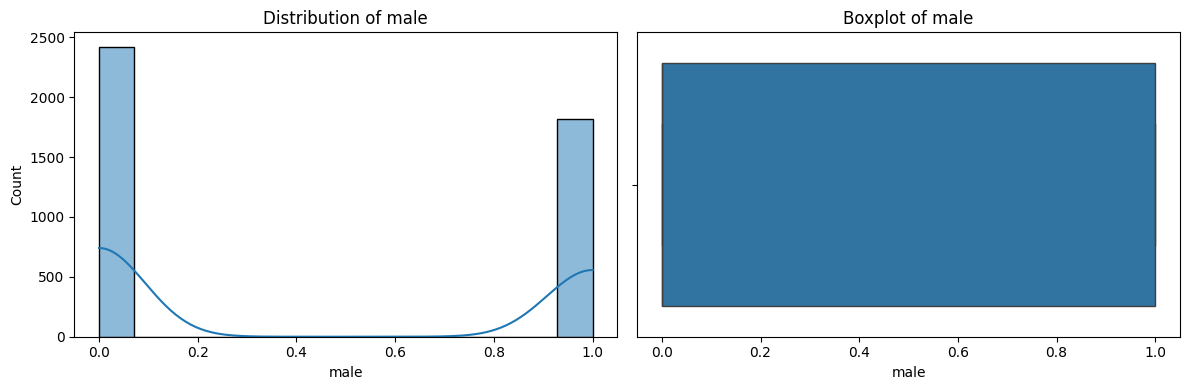

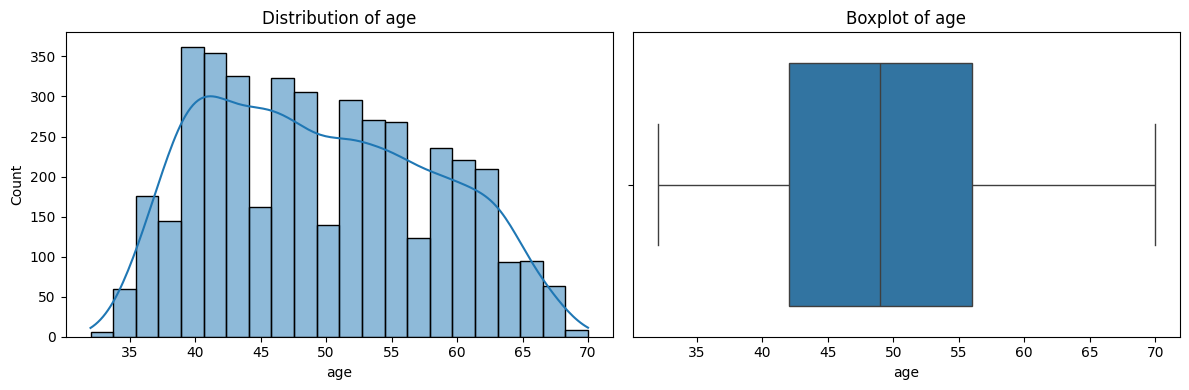

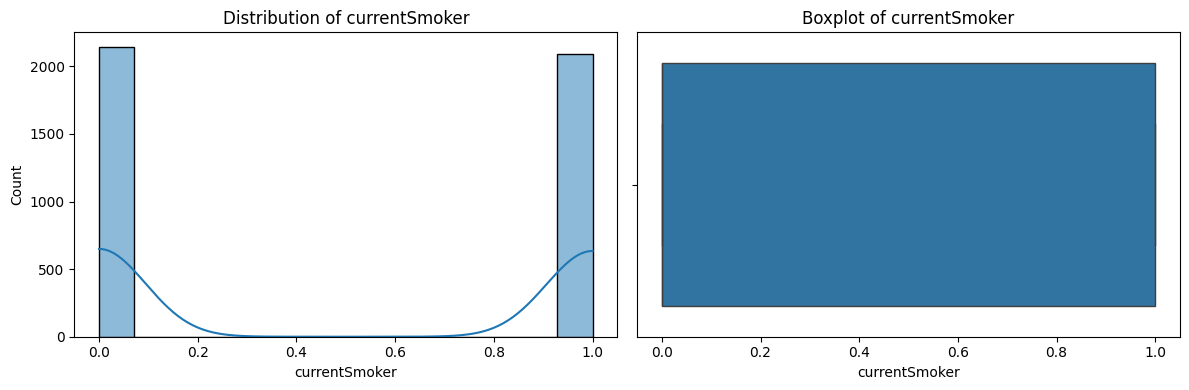

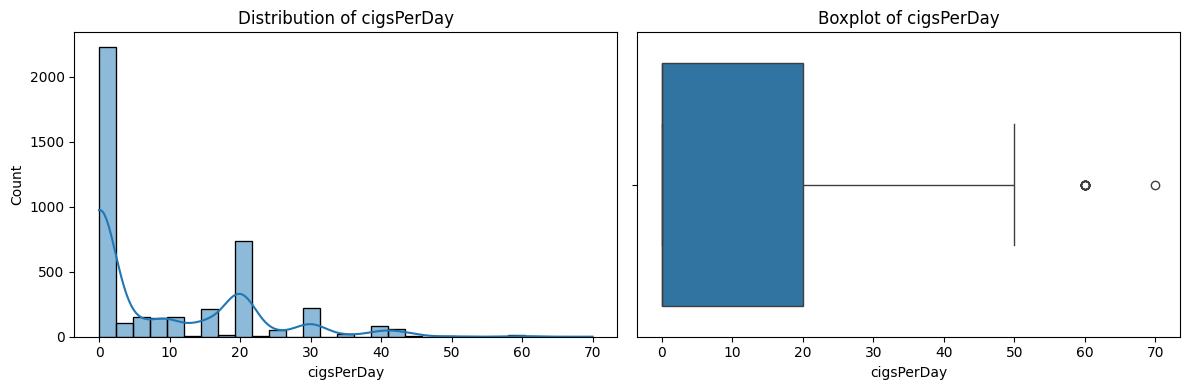

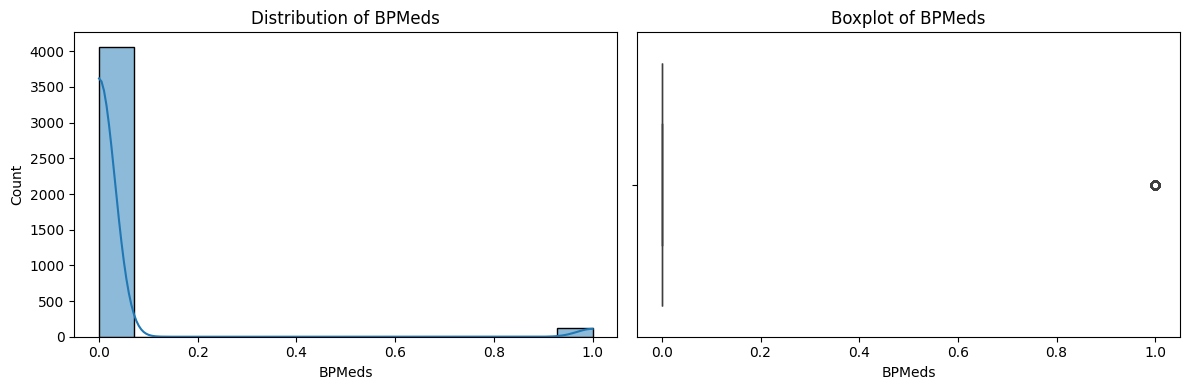

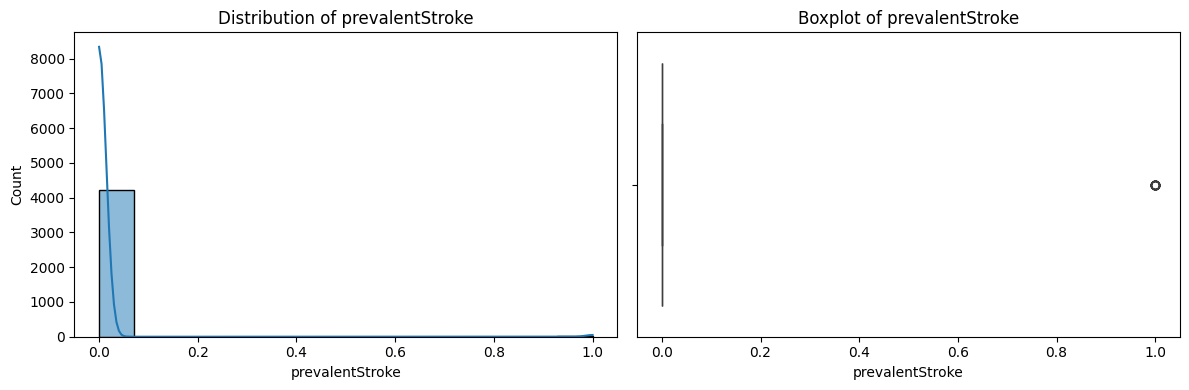

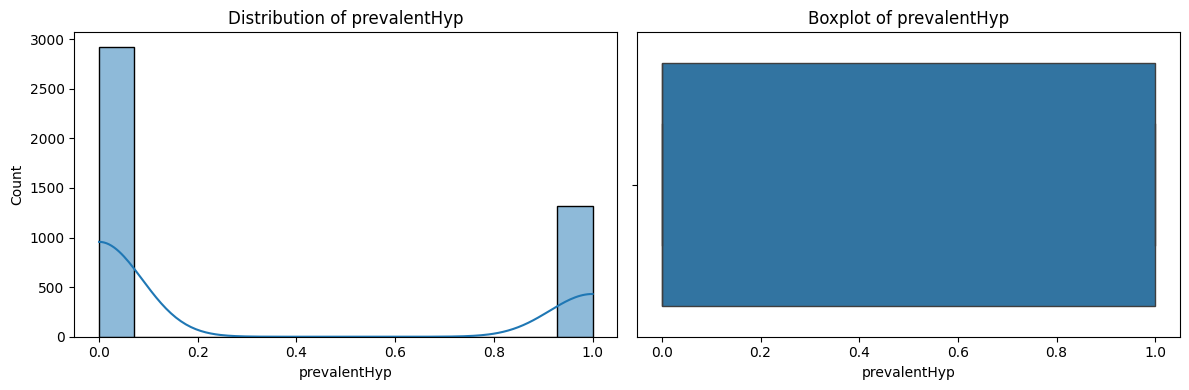

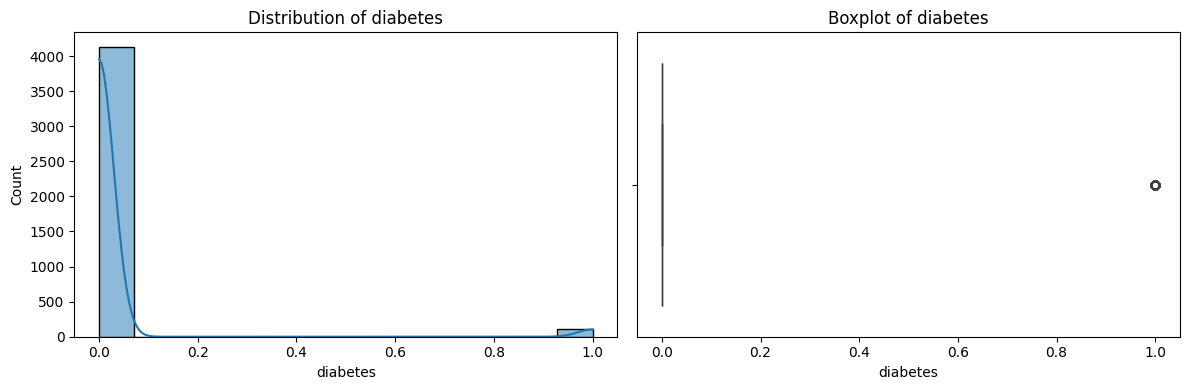

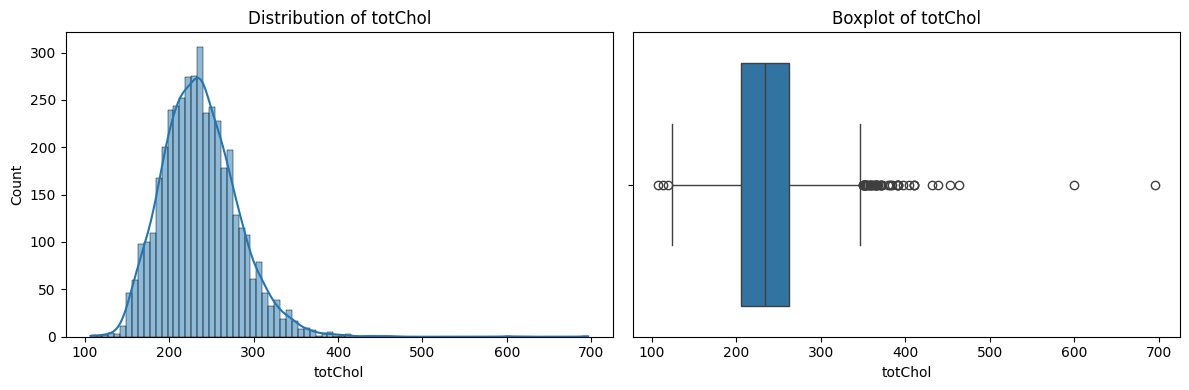

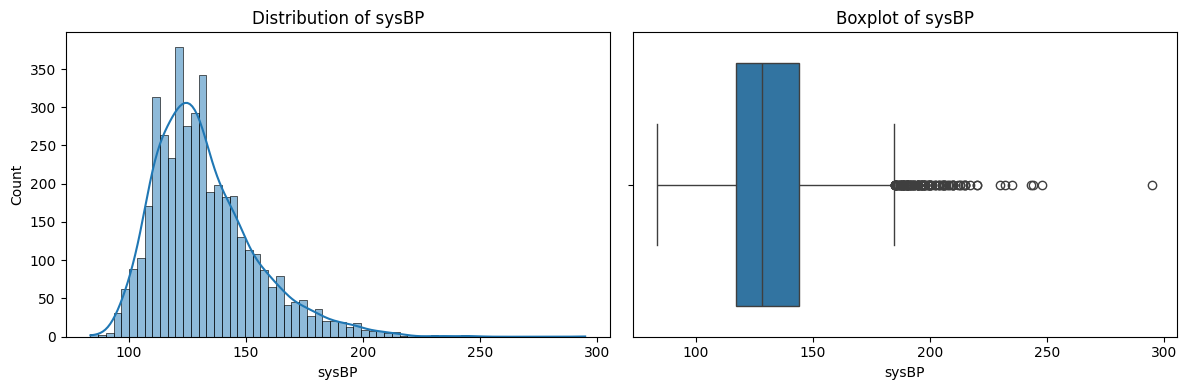

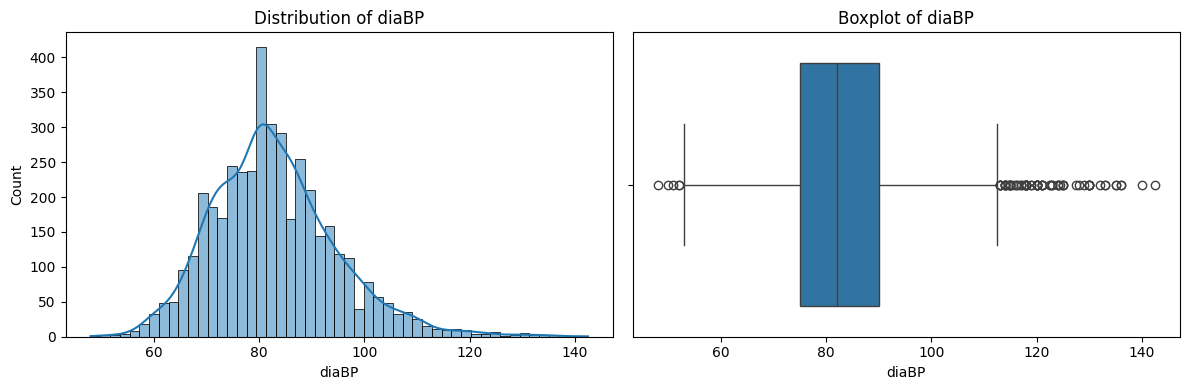

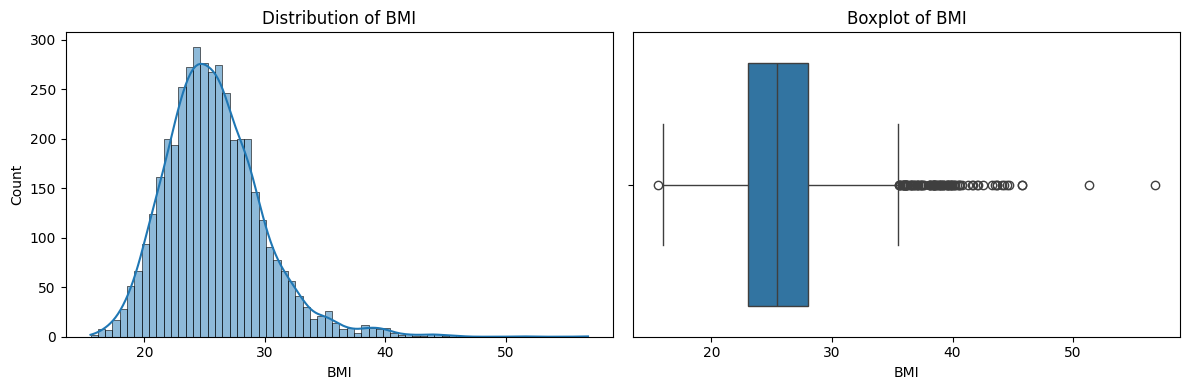

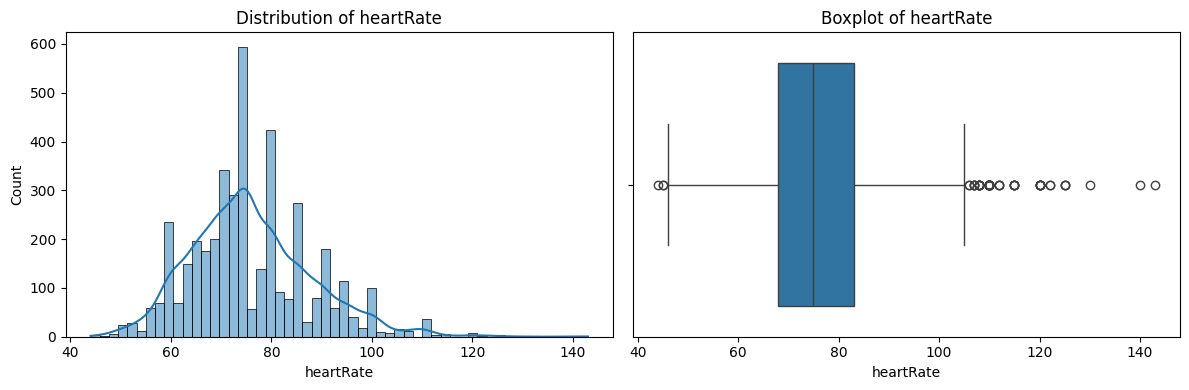

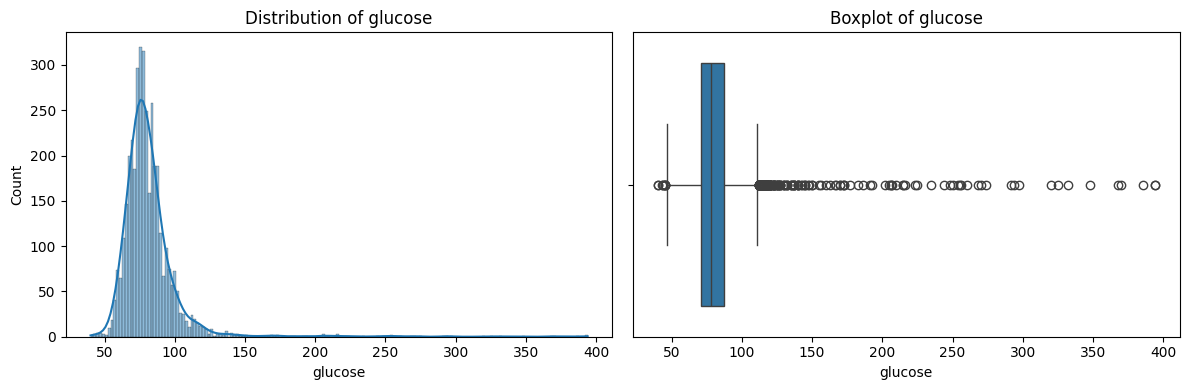

In [166]:
# Plot distribution and boxplot for each numeric column (excluding the target)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('TenYearCHD')
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram with KDE (distribution)
    sns.histplot(df[col].dropna(), kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {col}")

    # Boxplot for outlier detection
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.savefig(f'figures/{col}_distribution_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()

## 3.4 Correlation Heatmap
We use **Pearson correlation** to detect linear relationships and multicollinearity.

Based on the correlation matrix, the following feature pairs in our dataset exhibit relatively high collinearity (Pearson |r| > 0.7): currentSmoker & cigsPerDay (r = 0.77), sysBP & diaBP (r = 0.78), prevalentHyp & sysBP (r = 0.70), and diabetes & glucose (r = 0.62). However, since none of these correlations exceed our chosen threshold of 0.85 for dropping features, all are retained for further analysis. This approach allows us to preserve potentially informative variables while only removing features with very strong linear relationships, balancing the risk of multicollinearity with the benefit of a richer feature set.

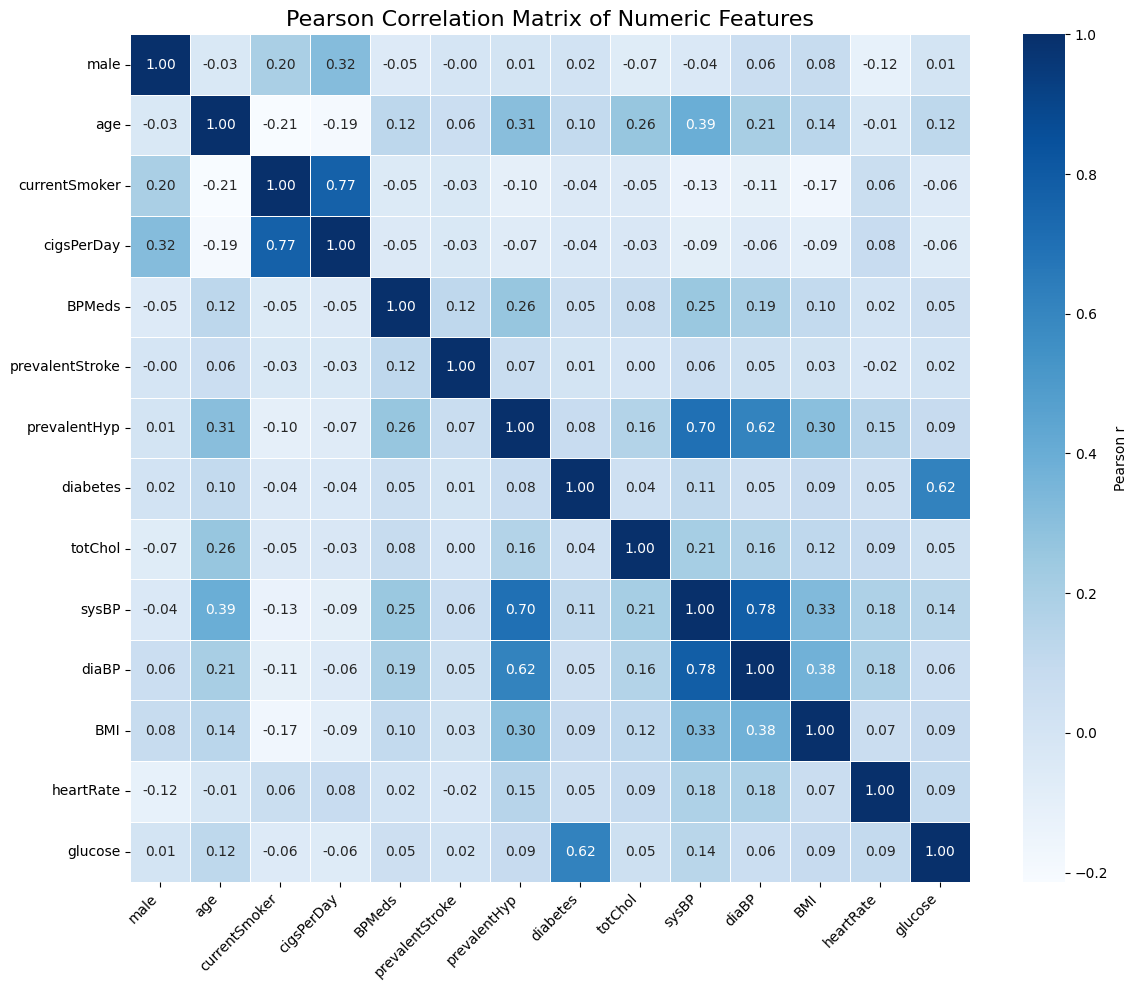

In [167]:
# Compute Pearson correlation between numeric features
grid = df[numeric_cols].corr(method='pearson')

# Plot correlation heatmap with annotations and bluish color scale
plt.figure(figsize=(12, 10))
sns.heatmap(
    grid,
    annot=True,
    fmt=".2f",
    cmap='Blues',  
    linewidths=0.5,
    cbar_kws={'label': 'Pearson r'}
)
plt.title('Pearson Correlation Matrix of Numeric Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the figure to the figures directory
plt.savefig('figures/pearson_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()



To reduce multicollinearity, we computed the absolute correlation matrix and identified pairs of features with a correlation higher than 0.85. The approach was to automatically drop one feature from each highly correlated pair to avoid redundancy and potential model overfitting.However, in this dataset, all feature correlations were found to be below the 0.85 threshold. Therefore, no features were dropped due to high correlation, indicating that multicollinearity is not a significant concern here.


In [168]:
# Automatically drop one feature from each pair with high correlation
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
df = df.drop(columns=to_drop)

## 3.5 Class Balance
Visualize the target distribution to confirm class imbalance (~15 % positives).

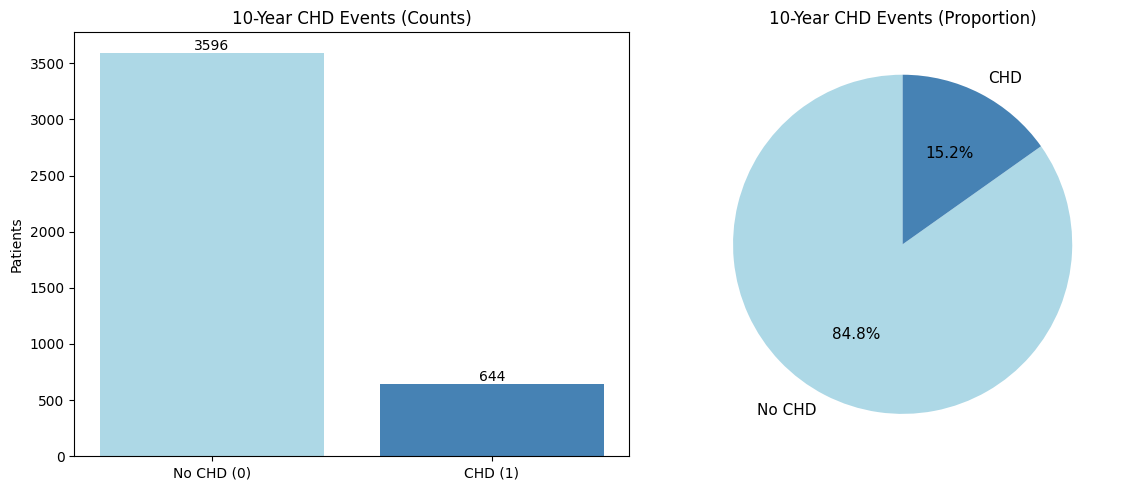

No CHD (0): 3,596 (84.8%)
CHD (1): 644 (15.2%)
Class imbalance ratio: 5.6:1
Total samples: 4,240


In [169]:
# Show class distribution of the target variable (bar + pie chart)
counts = df['TenYearCHD'].value_counts()
percentages = counts / counts.sum() * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
bars = ax1.bar(['No CHD (0)', 'CHD (1)'], counts, color=['lightblue', 'steelblue'])
ax1.set_title('10-Year CHD Events (Counts)')
ax1.set_ylabel('Patients')
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{int(count)}', ha='center', va='bottom')

# Pie chart
ax2.pie(counts, labels=['No CHD', 'CHD'], colors=['lightblue', 'steelblue'],
        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
ax2.set_title('10-Year CHD Events (Proportion)')

plt.tight_layout()
plt.savefig('figures/target_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
imbalance_ratio = counts[0] / counts[1]
print(f"No CHD (0): {counts[0]:,} ({percentages[0]:.1f}%)")
print(f"CHD (1): {counts[1]:,} ({percentages[1]:.1f}%)")
print(f"Class imbalance ratio: {imbalance_ratio:.1f}:1")
print(f"Total samples: {len(df):,}")

# 5  Train–Test Split
Stratified 70/30 to preserve class ratios; performed **before** imputation to avoid leakage.

In [170]:
# Split features and target variable
X = df.drop(columns=['TenYearCHD'])
y = df['TenYearCHD']

# Stratified train-test split (preserving distribution in classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2968, 14), Test shape: (1272, 14)


# 6  Pre-Processing Pipeline

We automatically identified numerical features based on their data types (`int64` and `float64`).

## Numerical Features

- **Median Imputation:**  
  Missing values are replaced with the median of each feature.

- **Winsorization:**  
  Values in the lower and upper 1% tails are capped to reduce the impact of extreme outliers.

- **Robust Scaling:**  
  Features are scaled using the RobustScaler, which is less sensitive to outliers.



These preprocessing steps ensure that the input data is clean, consistent, and scaled appropriately, improving the robustness and performance of the predictive models.

| Stage      | Transformer             | Purpose                  |
|------------|------------------------|--------------------------|
| Impute num | Median                  | handle NaNs              |
| Winsorize  | `FunctionTransformer`   | cap 1 %/99 % tails       |
| Scale      | `RobustScaler`          | resilient to outliers    |

In [171]:
# Identify numerical features automatically
numeric_feats = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Numeric preprocessing: median imputation, winsorization, robust scaling
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # fill missing values with median
    ('winsorizer', FunctionTransformer(
        lambda arr: np.apply_along_axis(lambda x: winsorize(x, limits=[0.01, 0.01]), 0, arr)
    )),  # cap outliers at 1st/99th percentiles
    ('scaler', RobustScaler())  # scale features robustly
])

# numeric features
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_feats)
])

Additionally, we evaluate model performance without any outlier handling 

In [172]:
# Numeric pipeline WITHOUT outlier handling 
numeric_pipeline_no_outlier = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),    # fill missing values with median
    ('scaler', RobustScaler())                        # scale features robustly (no winsorization)
])

# ColumnTransformer for numeric features only (no outlier handling)
preprocessor_no_outlier = ColumnTransformer([
    ('num', numeric_pipeline_no_outlier, numeric_feats)
])

# 7  Model Candidates & Hyperparameter Grids

We use three models—**Logistic Regression**, **XGBoost**, and **SVM**—each in a pipeline with preprocessing and SMOTEENN oversampling to handle class imbalance.

- **Pipeline steps:** preprocessing → SMOTEENN oversampling → classifier
- **Hyperparameters tuned:**
  - Logistic Regression: penalty (`l1`, `l2`), regularization `C`
  - XGBoost: max depth, learning rate, estimators, subsample
  - SVM: regularization `C`, kernel (`linear`, `rbf`), gamma (`scale`, `auto`)



In [173]:
# Random over-sampling strategy
oversampler = SMOTEENN(random_state=42)

# Define models and hyperparameter grids
models = {
    "LogisticRegression": {
        "pipeline": Pipeline([
            ('pre', preprocessor),
            ('over', oversampler),
            ('clf', LogisticRegression(solver='liblinear', random_state=42))
        ]),
        "params": {
            'clf__penalty': ['l1', 'l2'],
            'clf__C': [0.01, 0.1, 1, 10]
        }
    },
    "XGBoost": {
        "pipeline": Pipeline([
            ('pre', preprocessor),
            ('over', oversampler),
            ('clf', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
        ]),
        "params": {
            'clf__max_depth': [3, 5, 7],
            'clf__learning_rate': [0.01, 0.1],
            'clf__n_estimators': [100, 200],
            'clf__subsample': [0.8, 1.0]
        }
    },
    "SVM": {
        "pipeline": Pipeline([
            ('pre', preprocessor),
            ('over', oversampler),
            ('clf', SVC(probability=True, class_weight='balanced', random_state=42))
        ]),
        "params": {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf'],
            'clf__gamma': ['scale', 'auto']
        }
    }
}

models_no_outlier

In [174]:


# Define models and hyperparameter grids without outlier handling 
models_no_outlier = {
    "LogisticRegression": {
        "pipeline": Pipeline([
            ('pre', preprocessor_no_outlier),
            ('over', oversampler),
            ('clf', LogisticRegression(solver='liblinear', random_state=42))
        ]),
        "params": {
            'clf__penalty': ['l1', 'l2'],
            'clf__C': [0.01, 0.1, 1, 10]
        }
    },
    "XGBoost": {
        "pipeline": Pipeline([
            ('pre', preprocessor_no_outlier),
            ('over', oversampler),
            ('clf', XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42))
        ]),
        "params": {
            'clf__max_depth': [3, 5, 7],
            'clf__learning_rate': [0.01, 0.1],
            'clf__n_estimators': [100, 200],
            'clf__subsample': [0.8, 1.0]
        }
    },
    "SVM": {
        "pipeline": Pipeline([
            ('pre', preprocessor_no_outlier),
            ('over', oversampler),
            ('clf', SVC(probability=True, class_weight='balanced', random_state=42))
        ]),
        "params": {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf'],
            'clf__gamma': ['scale', 'auto']
        }
    }
}

# 8  Evaluation Function
This function trains a given model pipeline with hyperparameter tuning using **GridSearchCV** and evaluates its performance on the test set.
metrics:
  - AUC 
  - Accuracy
  - Precision
  - Recall
  - F1 Score





In [175]:
# Function to train model, tune hyperparameters, and evaluate performance
def evaluate_model(name, pipeline, params):
    print(f"\n{name} Evaluation")
    start = time.time()

    # Grid search with stratified 5-fold cross-validation
    grid = GridSearchCV(pipeline, params, scoring='roc_auc',
                        cv=StratifiedKFold(5, shuffle=True, random_state=42),
                        n_jobs=-1)
    grid.fit(X_train, y_train)
    end = time.time()
    train_time = end - start
    print("Training time: {:.2f} seconds".format(train_time))

    print("Best Params:", grid.best_params_)

    # Generate predictions and predicted probabilities
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]

    # Measure inference speed
    start_inf = time.time()
    _ = grid.predict(X_test)
    end_inf = time.time()
    inference_time = (end_inf - start_inf) / len(X_test) * 1000  # ms per sample
    print("Inference speed: {:.2f} ms/sample".format(inference_time))

    # Create summary DataFrame for this model
    summary = pd.DataFrame([{
        'Model': name,
        'AUC': roc_auc_score(y_test, y_proba),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Train Time (s)': train_time,
        'Inference Time (ms/sample)': inference_time
    }]).set_index('Model')

    return grid, y_pred, y_proba, summary

# 9  Run Evaluations
Iterate over all model configs, collect best estimators.


models without outlier handling 

In [176]:
# Evaluate models without outlier handling
fitted_no_outlier = {}
summaries_no_outlier = []
for name, cfg in models_no_outlier.items():
    grid, y_pred, y_proba, summary = evaluate_model(name + " (No Outlier Handling)", cfg['pipeline'], cfg['params'])
    fitted_no_outlier[name] = (grid, y_pred, y_proba)
    summaries_no_outlier.append(summary)
summary_table_no_outlier = pd.concat(summaries_no_outlier)
display(summary_table_no_outlier)


LogisticRegression (No Outlier Handling) Evaluation
Training time: 7.10 seconds
Best Params: {'clf__C': 1, 'clf__penalty': 'l2'}
Inference speed: 0.00 ms/sample

XGBoost (No Outlier Handling) Evaluation


c:\Users\kraie\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:36:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training time: 5.50 seconds
Best Params: {'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__n_estimators': 100, 'clf__subsample': 0.8}
Inference speed: 0.00 ms/sample

SVM (No Outlier Handling) Evaluation
Training time: 12.21 seconds
Best Params: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Inference speed: 0.02 ms/sample


,AUC,Accuracy,Precision,Recall,F1 Score,Train Time (s),Inference Time (ms/sample)
Model,,,,,,,
LogisticRegression (No Outlier Handling),0.698766,0.540094,0.220000,0.797927,0.344905,7.100313,0.001578
XGBoost (No Outlier Handling),0.685796,0.546384,0.215976,0.756477,0.336018,5.497259,0.002358
SVM (No Outlier Handling),0.697916,0.623428,0.239051,0.678756,0.353576,12.212114,0.022801


models with  outlier handling 

In [177]:
fitted = {}
summaries = []
for name, cfg in models.items():
    grid, y_pred, y_proba, summary = evaluate_model(name, cfg['pipeline'], cfg['params'])
    fitted[name] = (grid, y_pred, y_proba)
    summaries.append(summary)
summary_table_default = pd.concat(summaries)
summary_table_default


LogisticRegression Evaluation
Training time: 0.53 seconds
Best Params: {'clf__C': 10, 'clf__penalty': 'l2'}
Inference speed: 0.00 ms/sample

XGBoost Evaluation


c:\Users\kraie\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:36:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training time: 4.11 seconds
Best Params: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Inference speed: 0.00 ms/sample

SVM Evaluation
Training time: 7.91 seconds
Best Params: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Inference speed: 0.02 ms/sample


,AUC,Accuracy,Precision,Recall,F1 Score,Train Time (s),Inference Time (ms/sample)
Model,,,,,,,
LogisticRegression,0.696111,0.541667,0.219828,0.792746,0.344207,0.525831,0.003145
XGBoost,0.687693,0.551887,0.220741,0.772021,0.343318,4.105373,0.003932
SVM,0.696171,0.621069,0.239640,0.689119,0.355615,7.909674,0.022020


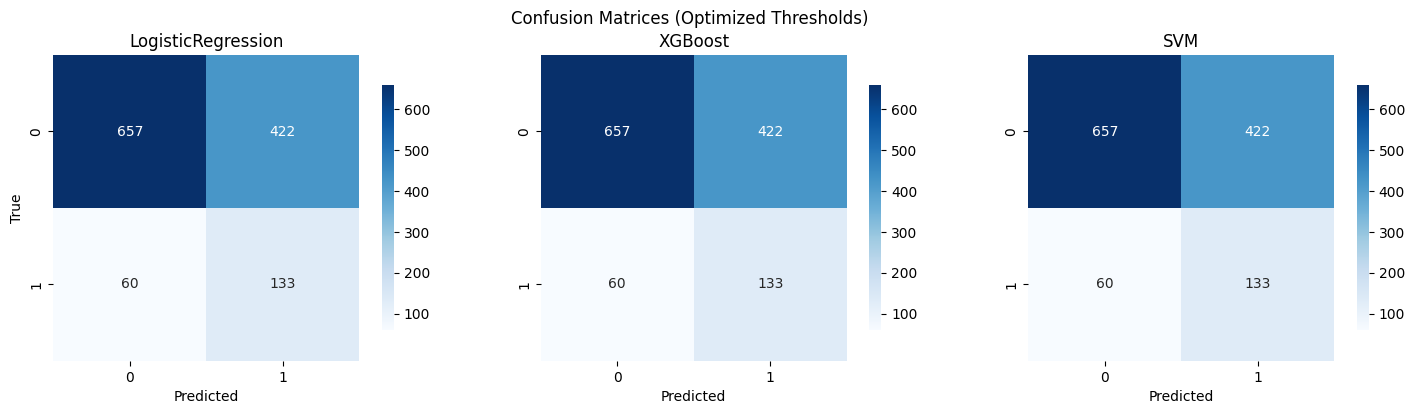

In [178]:

# Create composite confusion matrices using optimized thresholds
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, model_results) in enumerate(fitted.items()):
    grid, _, y_proba = model_results
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                cbar_kws={'shrink': 0.8}, square=True)
    axes[i].set_title(f'{name}')
    axes[i].set_ylabel('True' if i == 0 else '')
    axes[i].set_xlabel('Predicted')

plt.suptitle('Confusion Matrices (Optimized Thresholds)')
plt.tight_layout()
plt.savefig('figures/all_confusion_matrices_optimized.png')
plt.show()


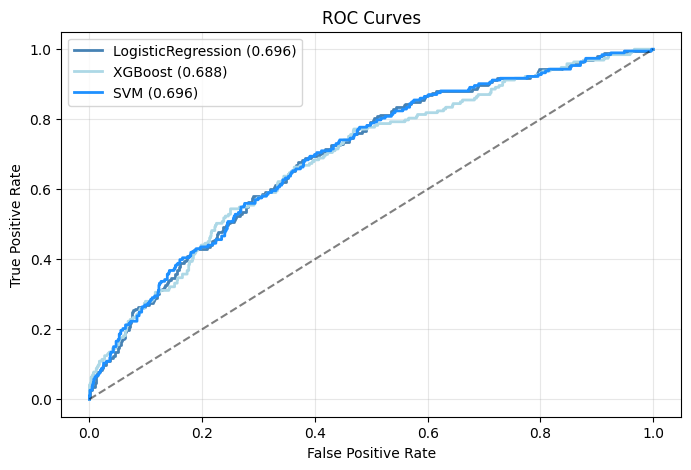

In [179]:

# ROC curves 
plt.figure(figsize=(8, 5))
colors = ['steelblue', 'lightblue', 'dodgerblue']  
for i, (name, model_results) in enumerate(fitted.items()):
    grid = model_results[0]  # GridSearchCV object
    y_proba = grid.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} ({auc:.3f})', color=colors[i], linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figures/all_roc_curves.png')
plt.show()


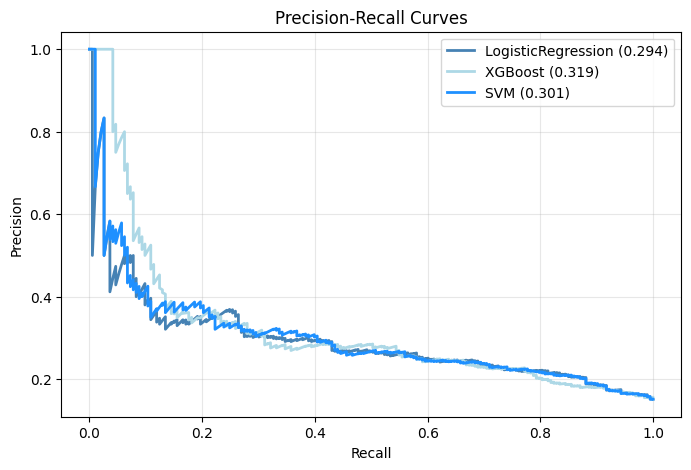

In [180]:

# Precision-Recall curves 
plt.figure(figsize=(8, 5))
for i, (name, model_results) in enumerate(fitted.items()):
    grid = model_results[0]  # GridSearchCV object
    y_proba = grid.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f'{name} ({ap:.3f})', color=colors[i], linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('figures/all_precision_recall_curves.png')
plt.show()

# 10  Threshold Tuning
For our medical prediction task we need to achieve a high recall. To ensure this we lower the threshold (default was 0.5).

We calculate the optimal threshold which achieves highest recall. We also print the respective precision and F1 score for each model to get insight into the trade-off.

In [181]:
best_thresholds = {}
results = []

for model_name, model_results in fitted.items():
    model, _, y_proba = model_results

    best_threshold = 0.5
    best_recall = 0.0
    best_precision = 0.0
    best_f1 = 0.0

    thresholds = np.arange(0.1, 0.9, 0.05)

    for t in thresholds:
        preds = (y_proba >= t).astype(int)
        recall = recall_score(y_test, preds)
        precision = precision_score(y_test, preds)
        f1 = f1_score(y_test, preds)

        if recall > best_recall:
            best_threshold = t
            best_recall = recall
            best_precision = precision
            best_f1 = f1

    # Store the best threshold for this model
    best_thresholds[model_name] = best_threshold

    print(f"{model_name} - Best Threshold: {best_threshold:.2f}")
    print(f"Recall: {best_recall:.3f}")
    print(f"Precision: {best_precision:.3f}")
    print("F1 Score: {best_f1:.3f}")
    


LogisticRegression - Best Threshold: 0.10
Recall: 0.990
Precision: 0.159
F1 Score: {best_f1:.3f}
XGBoost - Best Threshold: 0.10
Recall: 1.000
Precision: 0.152
F1 Score: {best_f1:.3f}
SVM - Best Threshold: 0.10
Recall: 0.990
Precision: 0.158
F1 Score: {best_f1:.3f}


The best threshold appears to be 0.1, meaning:

If the model thinks there's at least a 10% chance of coronary heart disease, it will classify the person as positive (`TenYearCHD = 1`).
This will increase our chance of detecting positives (recall/ sensitivity).
* Drawback: We will have more false positives (more healthy people are classified as developing CHD).

**We plot recall and precision for different thresholds to understand our precision-recall tradeoff.**

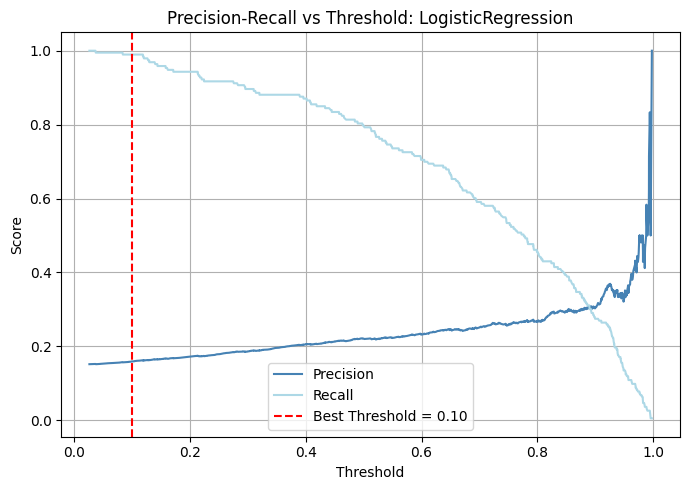

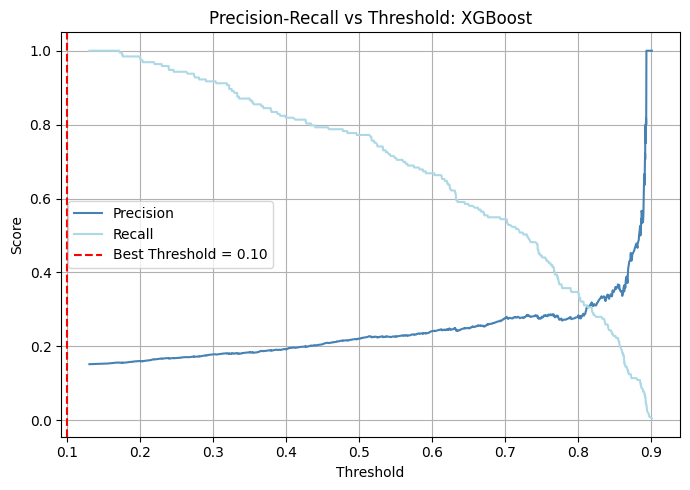

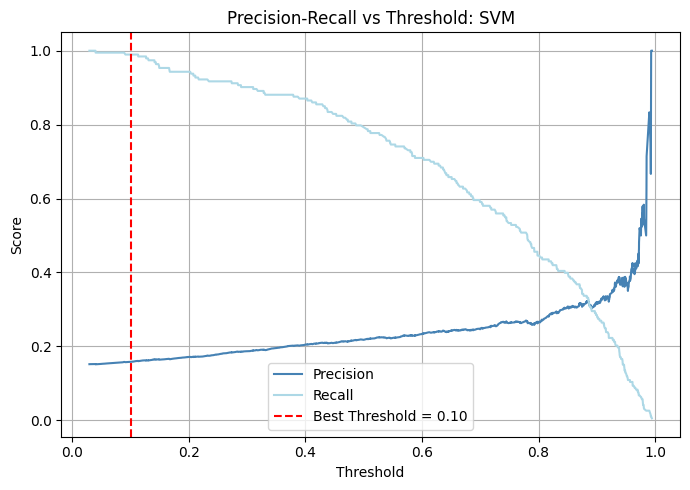

In [182]:
for name, (grid, _, y_proba) in fitted.items():
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

    plt.figure(figsize=(7, 5))
    plt.plot(thresholds, precision[:-1], label="Precision", color='steelblue')
    plt.plot(thresholds, recall[:-1], label="Recall", color='lightblue')
    plt.axvline(best_thresholds[name], color='red', linestyle='--', label=f"Best Threshold = {best_thresholds[name]:.2f}")
    plt.title(f"Precision-Recall vs Threshold: {name}")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/precision_recall_vs_threshold_{name}.png', dpi=300, bbox_inches='tight')
    plt.show()

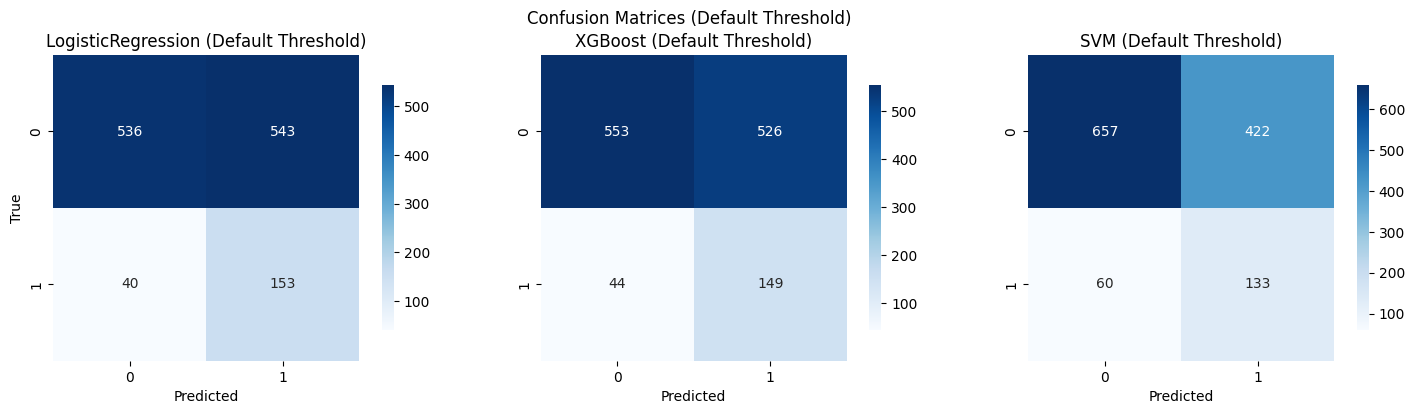

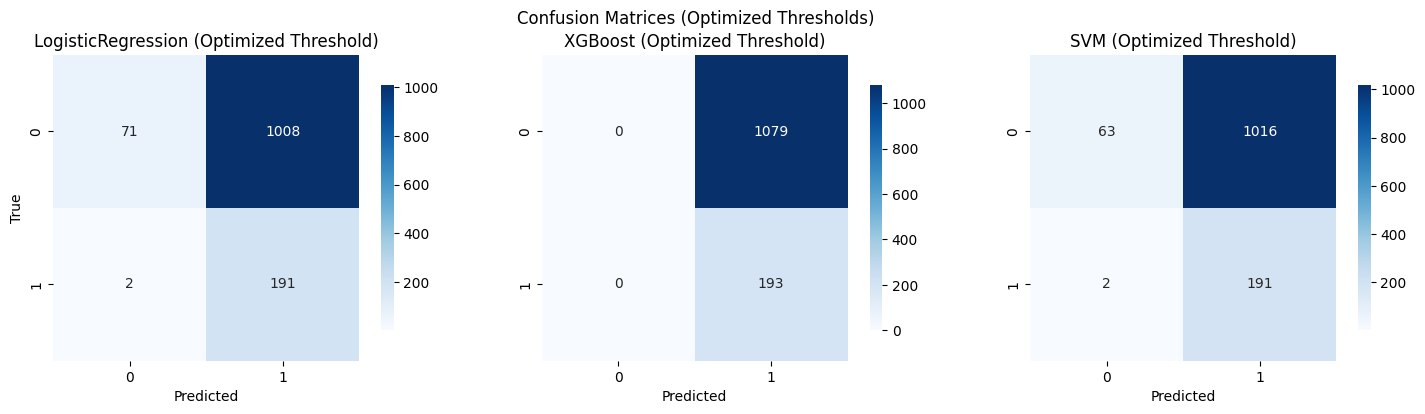

In [183]:
from sklearn.metrics import confusion_matrix

# Plot confusion matrices for each model using default threshold (0.5)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, (name, model_results) in enumerate(fitted.items()):
    grid, y_pred, _ = model_results  # y_pred uses default threshold
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                cbar_kws={'shrink': 0.8}, square=True)
    axes[i].set_title(f'{name} (Default Threshold)')
    axes[i].set_ylabel('True' if i == 0 else '')
    axes[i].set_xlabel('Predicted')
plt.suptitle('Confusion Matrices (Default Threshold)')
plt.tight_layout()
plt.savefig('figures/all_confusion_matrices_default.png')
plt.show()

# Plot confusion matrices for each model using optimized threshold (threshold tuning)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, (name, model_results) in enumerate(fitted.items()):
    grid, _, y_proba = model_results
    threshold = best_thresholds[name]
    y_pred_opt = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_opt)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                cbar_kws={'shrink': 0.8}, square=True)
    axes[i].set_title(f'{name} (Optimized Threshold)')
    axes[i].set_ylabel('True' if i == 0 else '')
    axes[i].set_xlabel('Predicted')
plt.suptitle('Confusion Matrices (Optimized Thresholds)')
plt.tight_layout()
plt.savefig('figures/all_confusion_matrices_optimized.png')

## 11 Comparative Analysis - Summary
Overview of evaluation metrics after threshold-tuning.

In [184]:
# Compile evaluation metrics into a summary DataFrame (with threshold tuning)
results = []
for name, (model, _, y_proba) in fitted.items():
    t = best_thresholds[name]
    y_pred = (y_proba >= t).astype(int)
    results.append({
        'Model': name,
        'Best Threshold': round(t, 2),
        'AUC': roc_auc_score(y_test, y_proba),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

# Display model comparison summary
summary_table_optimized = pd.DataFrame(results).set_index('Model')

print(summary_table_default)


print(summary_table_optimized)


                         AUC  Accuracy  Precision    Recall  F1 Score  \
Model                                                                   
LogisticRegression  0.696111  0.541667   0.219828  0.792746  0.344207   
XGBoost             0.687693  0.551887   0.220741  0.772021  0.343318   
SVM                 0.696171  0.621069   0.239640  0.689119  0.355615   

                    Train Time (s)  Inference Time (ms/sample)  
Model                                                           
LogisticRegression        0.525831                    0.003145  
XGBoost                   4.105373                    0.003932  
SVM                       7.909674                    0.022020  
                    Best Threshold       AUC  Accuracy  Precision    Recall  \
Model                                                                         
LogisticRegression             0.1  0.696111  0.205975   0.159299  0.989637   
XGBoost                        0.1  0.687693  0.151730   0.151730  1.000

C:\Users\kraie\AppData\Local\Temp\ipykernel_14668\1987058380.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


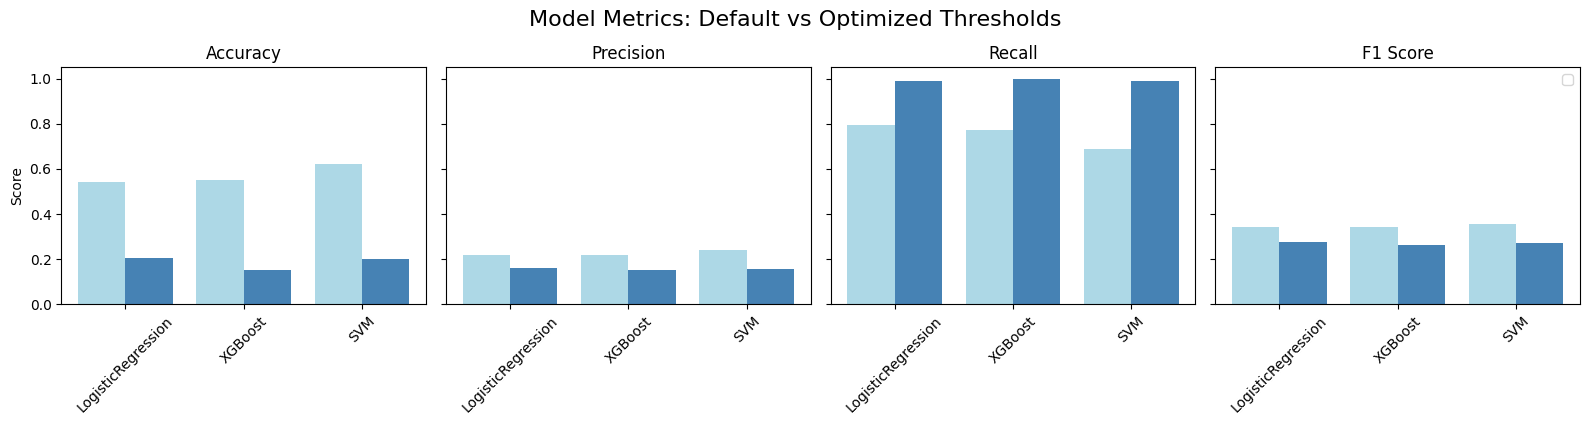

In [185]:
# Only plot metrics that change with threshold tuning
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models = summary_table_default.index

# Prepare data for plotting
df_plot = pd.concat([
    summary_table_default[metrics].assign(Type='Default'),
    summary_table_optimized[metrics].assign(Type='Optimized')
]).reset_index()

df_melt = df_plot.melt(id_vars=['Model', 'Type'], value_vars=metrics, var_name='Metric', value_name='Score')

# Plot grouped bar charts for each metric
fig, axes = plt.subplots(1, len(metrics), figsize=(16, 4), sharey=True)
for i, metric in enumerate(metrics):
    ax = axes[i]
    subset = df_melt[df_melt['Metric'] == metric]
    for j, model in enumerate(models):
        vals = subset[subset['Model'] == model]
        ax.bar(j - 0.2, vals[vals['Type'] == 'Default']['Score'], width=0.4, label='Default' if i == 0 else "", color='lightblue')
        ax.bar(j + 0.2, vals[vals['Type'] == 'Optimized']['Score'], width=0.4, label='Optimized' if i == 0 else "", color='steelblue')
    ax.set_title(metric)
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45)
    if i == 0:
        ax.set_ylabel('Score')
    if i == len(metrics) - 1:
        ax.legend()
plt.tight_layout()
plt.suptitle('Model Metrics: Default vs Optimized Thresholds', y=1.05, fontsize=16)
plt.show()



### Best Model Selection

The **SVM** is the best performing model, showing the highest F1 Score and Accuracy while maintaining a high AUC, though the differences are marginal.

- All models have very high **Recall** values (~0.99 or 1.0) after threshold tuning, meaning they are excellent at identifying positive cases (minimizing false negatives).
- However, this high recall comes with low precision, indicating many false positives.
- The SVM balances this trade-off slightly better, with marginally higher precision and F1 Score compared to Logistic Regression and XGBoost.

Thus, the SVM provides the best overall balance between correctly detecting positive cases (**Recall**) and avoiding false alarms (**Precision**), making it the preferred model for this dataset.

# 12  Fairness Audit – Recall by Gender
We compute recall separately for males vs. females and print the gap.


Fairness Audit: Recall by Gender (default threshold 0.5)
LogisticRegression Male Recall: 0.864
LogisticRegression Female Recall: 0.699
XGBoost Male Recall: 0.827
XGBoost Female Recall: 0.699
SVM Male Recall: 0.764
SVM Female Recall: 0.590


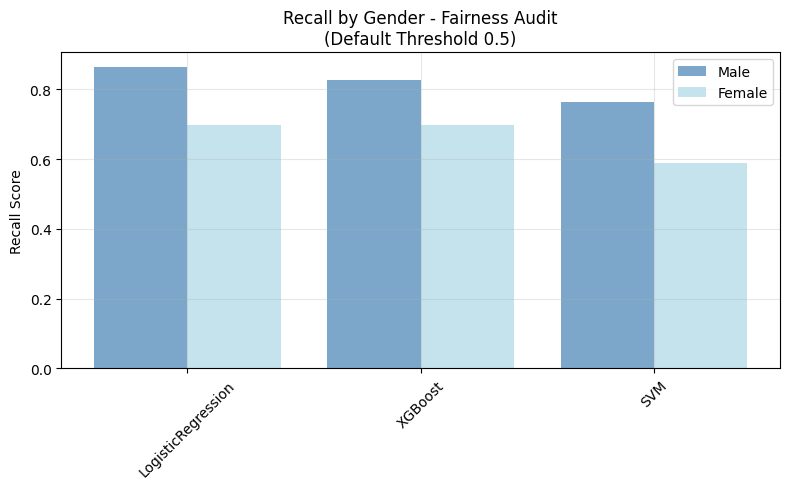

In [186]:
# Fairness Audit: Recall by Gender (Default Threshold 0.5)
print("\nFairness Audit: Recall by Gender (default threshold 0.5)")
df_test = X_test.copy()
df_test['true'] = y_test

male_scores_default = []
female_scores_default = []
model_names = list(fitted.keys())

for name, (model, y_pred, _) in fitted.items():
    df_test['pred'] = y_pred  # y_pred uses default threshold 0.5
    # Male recall
    mask_male = df_test['male'] == 1
    rec_male = recall_score(df_test.loc[mask_male, 'true'], df_test.loc[mask_male, 'pred'])
    male_scores_default.append(rec_male)
    print(f"{name} Male Recall: {rec_male:.3f}")
    # Female recall
    mask_female = df_test['male'] == 0
    rec_female = recall_score(df_test.loc[mask_female, 'true'], df_test.loc[mask_female, 'pred'])
    female_scores_default.append(rec_female)
    print(f"{name} Female Recall: {rec_female:.3f}")

# Visualization (optional)
x = range(len(model_names))
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar([i-0.2 for i in x], male_scores_default, 0.4, label='Male', alpha=0.7, color='steelblue')
ax.bar([i+0.2 for i in x], female_scores_default, 0.4, label='Female', alpha=0.7, color='lightblue')
ax.set_xticks(list(x))
ax.set_xticklabels(model_names, rotation=45)
ax.set_ylabel('Recall Score')
ax.set_title('Recall by Gender - Fairness Audit\n(Default Threshold 0.5)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/fairness_audit_default_threshold.png', dpi=300, bbox_inches='tight')
plt.show()


Fairness Audit: Recall by Gender (using best threshold)
LogisticRegression Male Recall: 1.000
LogisticRegression Female Recall: 0.976
XGBoost Male Recall: 1.000
XGBoost Female Recall: 1.000
SVM Male Recall: 1.000
SVM Female Recall: 0.976


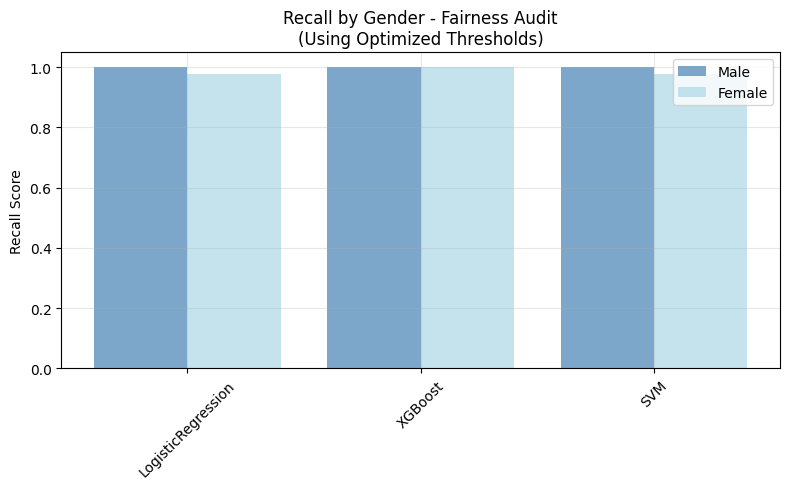

In [187]:
# Evaluate recall per respective gender for fairness check (using best threshold)
print("\nFairness Audit: Recall by Gender (using best threshold)")
df_test = X_test.copy()
df_test['true'] = y_test

male_scores = []
female_scores = []
model_names = list(fitted.keys())

for name, (model, _, y_proba) in fitted.items():
    threshold = best_thresholds[name]
    df_test['pred'] = (y_proba >= threshold).astype(int)
    # Male recall
    mask_male = df_test['male'] == 1
    rec_male = recall_score(df_test.loc[mask_male, 'true'], df_test.loc[mask_male, 'pred'])
    male_scores.append(rec_male)
    print(f"{name} Male Recall: {rec_male:.3f}")
    # Female recall
    mask_female = df_test['male'] == 0
    rec_female = recall_score(df_test.loc[mask_female, 'true'], df_test.loc[mask_female, 'pred'])
    female_scores.append(rec_female)
    print(f"{name} Female Recall: {rec_female:.3f}")

# Create visualization
x = range(len(model_names))
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar([i-0.2 for i in x], male_scores, 0.4, label='Male', alpha=0.7, color='steelblue')
ax.bar([i+0.2 for i in x], female_scores, 0.4, label='Female', alpha=0.7, color='lightblue')
ax.set_xticks(list(x))
ax.set_xticklabels(model_names, rotation=45)
ax.set_ylabel('Recall Score')
ax.set_title('Recall by Gender - Fairness Audit\n(Using Optimized Thresholds)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/fairness_audit_optimized_thresholds.png', dpi=300, bbox_inches='tight')
plt.show()